In [126]:
import pymongo
import pandas as pd
client = pymongo.MongoClient('da1.eecs.utk.edu')
data = list(client['fdac19-Stackbot']['SOdata'].find())
df = pd.DataFrame(data)
removed = []
data = pd.DataFrame() # Used in the Random Forest Model

# print(len(df)) # Length before cleaning

# Finds all dictionaries in df['code_and_ast'] that need to be removed
# i.e. all questions that do not contain any code
for i in df.index:
    for j in df['code_and_ast'][i]:
        if j['ast'] == 'none':
            removed.append((i, j))
            
# Handles the removal process from df using the removed list
for x in removed:        
    if (df.at[x[0], 'code_and_ast'] is not None):
        (df.at[x[0], 'code_and_ast']).remove(x[1])
        if len(df.at[x[0], 'code_and_ast']) == 0:
            df.at[x[0], 'code_and_ast'] = None
    else:
        print('Something went wrong! :(')

# Removes all df rows that are non-null
df = df[df['code_and_ast'].notnull()] 

df.reset_index(inplace=True) # Resets index from 1, 3, 5 --> 1, 2, 3 etc.

# Build a static list of tags (that need to be predicted) based off of the df
# Input feature set: 
for i in df.index:
    for cat in df.at[i, 'code_and_ast']:
        for tag in df.at[i, 'tags']:
            if cat['ast'] is not None:
                d = {'ast': [cat['ast']], 'tag': [tag]}
                # Wow nice PANDAS this is not how append should works
                data = data.append(pd.DataFrame(d), ignore_index=True)

                                                     ast  \
0      Module(body=[Assign(targets=[Name(id='match', ...   
1      Module(body=[Assign(targets=[Name(id='match', ...   
2      Module(body=[While(test=Compare(left=Name(id='...   
3      Module(body=[While(test=Compare(left=Name(id='...   
4      Module(body=[While(test=Compare(left=Name(id='...   
5      Module(body=[Import(names=[alias(name='matplot...   
6      Module(body=[Import(names=[alias(name='matplot...   
7      Module(body=[Import(names=[alias(name='matplot...   
8      Module(body=[Import(names=[alias(name='matplot...   
9      Module(body=[ImportFrom(module='oauthlib.oauth...   
10     Module(body=[ImportFrom(module='oauthlib.oauth...   
11     Module(body=[ImportFrom(module='oauthlib.oauth...   
12     Module(body=[ImportFrom(module='oauthlib.oauth...   
13     Module(body=[ImportFrom(module='oauthlib.oauth...   
14     Module(body=[Assign(targets=[Name(id='energyst...   
15     Module(body=[ImportFrom(module='x

In [ ]:
from pd_doc2vec_threaded import doc2vec

# Converts the data tag field into a set for float usage within our model
tag_set = set(data['tag'])

tag_dict = {}
for i, x in enumerate(tag_set):
    tag_dict.update({x:i})
    
print(tag_dict)

data['tag_val'] = None
for x in data.index:
    data.at[x, 'tag_val'] = tag_dict[data.at[x, 'tag']]

# This is our model
# stack_brain = doc2vec(data, 'ast', ['tag_val'])

tag_val


100%|██████████| 10/10 [58:10<00:00, 349.03s/it]  


Best Accuracy: 0.003121748178980229
Labeled F1 Score: 
Tag  F1 Score  Recall Score  Precision Score
   0.0         0           0.0              0.0
   3.0         0           0.0              0.0
   4.0         0           0.0              0.0
   8.0         0           0.0              0.0
   9.0         0           0.0              0.0
  11.0         0           0.0              0.0
  13.0         0           0.0              0.0
  17.0         0           0.0              0.0
  20.0         0           0.0              0.0
  22.0         0           0.0              0.0
  25.0         0           0.0              0.0
  26.0         0           0.0              0.0
  28.0         0           0.0              0.0
  29.0         0           0.0              0.0
  34.0         0           0.0              0.0
  37.0         0           0.0              0.0
  41.0         0           0.0              0.0
  44.0         0           0.0              0.0
  45.0         0           0.0      

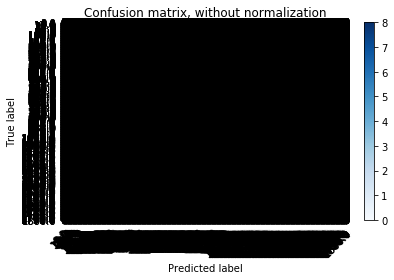

In [ ]:
# This is the training
stack_brain.score(verbose=True, iterations=10)